# “上帝”的算法—期望最大化算法（Expectation-Maximization Alogrigthm，EM）

EM算法是一种迭代优化算法，用于含有隐变量（latent variable）的概率参数模型的最大似然估计或极大后验概率估计。

EM 算法的核心思想非常简单，分为两步：Expection-Step 和 Maximization-Step。E-Step 主要通过观察数据和现有模型来估计参数，然后用这个估计的参数值来计算似然函数的期望值；而 M-Step 是寻找似然函数最大化时对应的参数。由于算法会保证在每次迭代之后似然函数都会增加，所以函数最终会收敛。



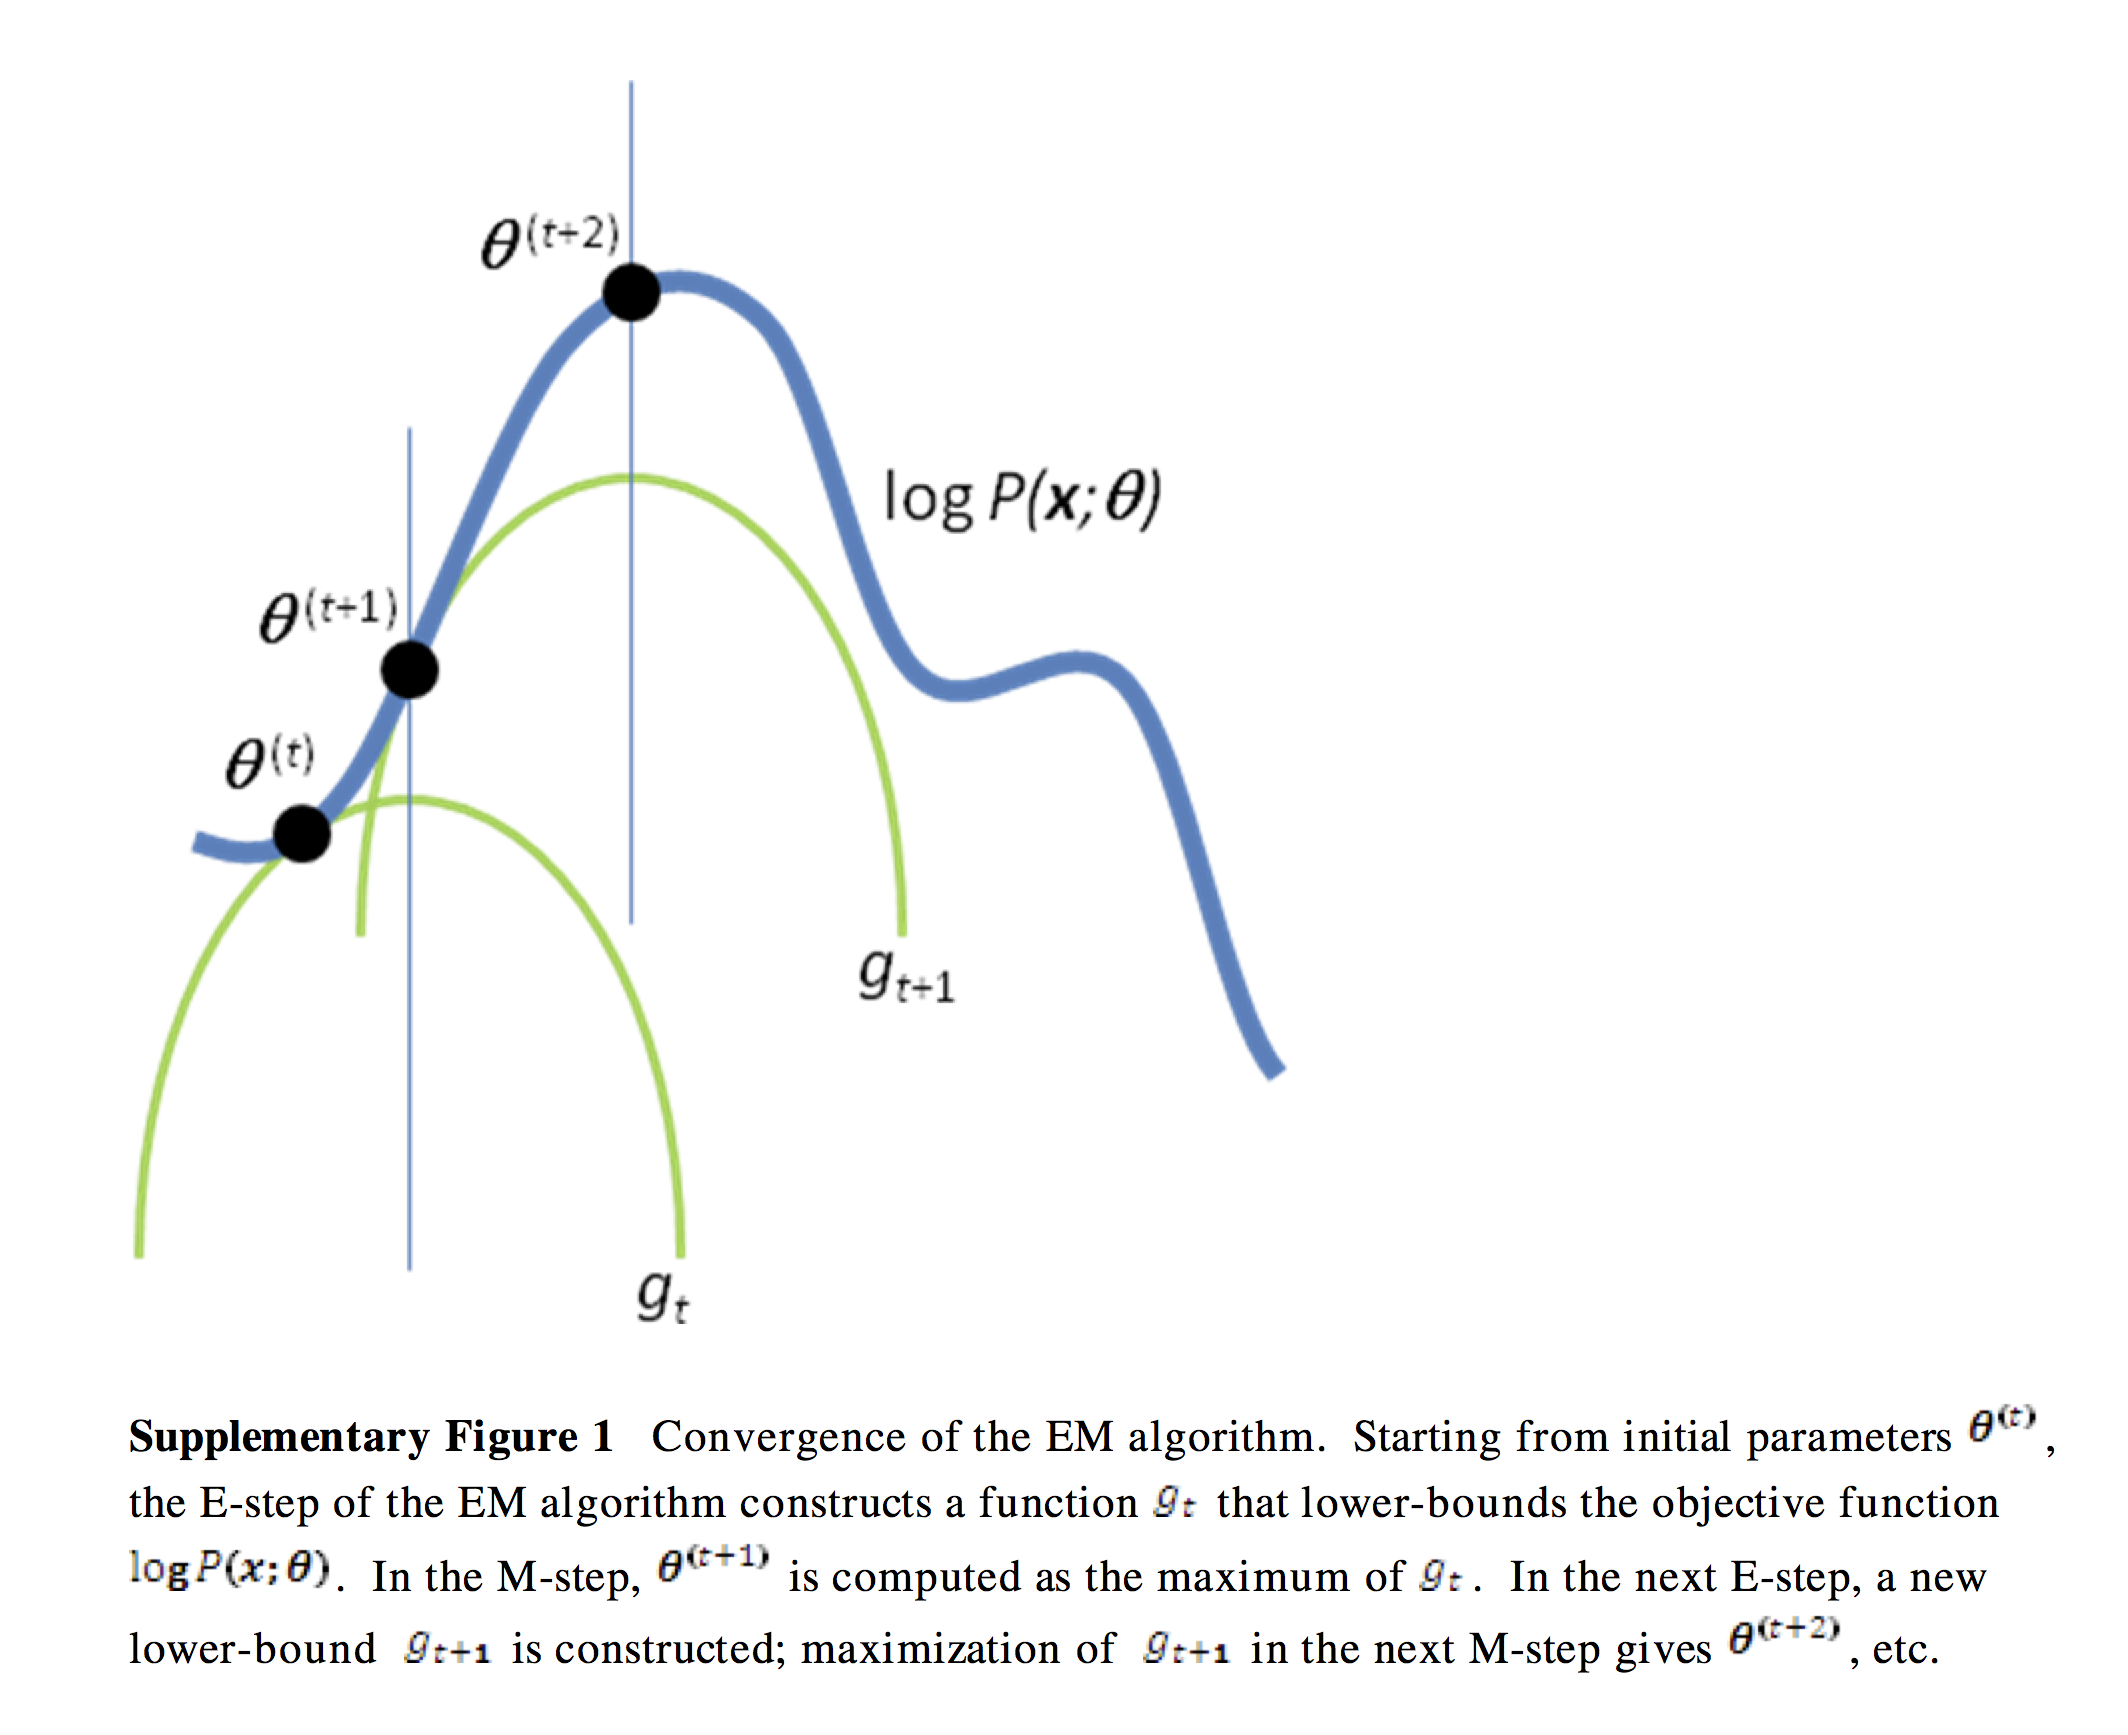

### 1. 不含有隐变量的例子

假设有A、B两枚硬币，硬币正面向上的概率都不一样（分别为$\theta_A,\theta_B$)。每次分别有选择的拿一枚硬币扔10次记录正反面出现的次数。以上过程共执行5次，那么怎么计算两枚硬币正面向上的概率呢？

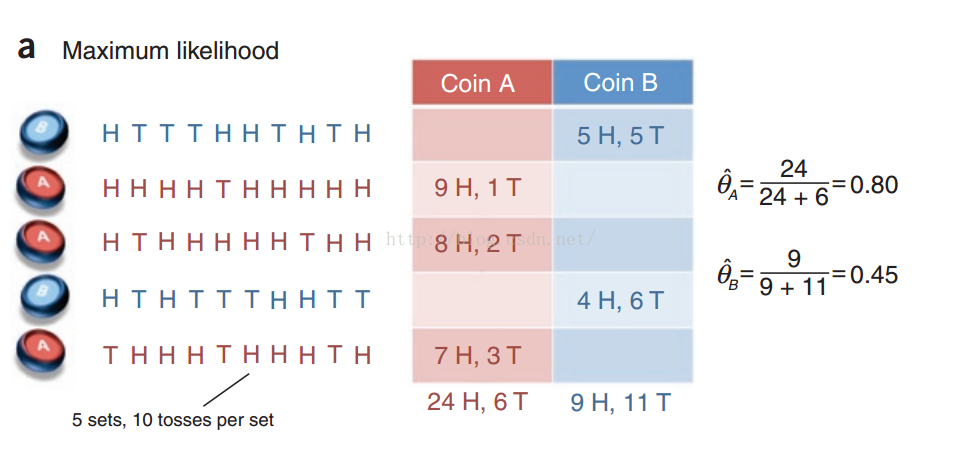

可以采用概率论中的大数定律思想来解决：由于知道每次拿的是哪枚硬币，因此分别统计硬币A和硬币B正面向上的次数，并除以总次数即可。如上图。

### 2. 含有隐变量的例子

如果不知道每次抛的是哪个硬币呢？即每次随机取一枚硬币（并不知道取A还是B）然后抛10次记录，以上过程执行5轮。

- 此时，由于不知道每一个样本是哪枚硬币，因此无法通过大数定律计算$\theta_A$和$\theta_B$
- 归根结底是由于存在一个未知的隐变量$z$（其中$z=A$或者$z=B$），需要知道每个样本以及相关联的因变量的值

这种情况下，随机梯度下降法也不能很好的工作，此时就需要通过反复迭代参数和隐变量（$z$以及$\theta_A$和$\theta_B$)来实现参数估计。

### 3. 硬币模型的EM算法

1. 随机初始化一组参数值$\theta_A=a$和$\theta_B=b$
2. 用$\theta_A$和$\theta_B$估计每轮扔硬币是A还是B的概率，并求正面和反面的期望（E步）
3. 根据求得的期望值，计算正面期望除以总期望分别更新$\theta_A$和$\theta_B$的值（M步）
4. 重复以上过程直至收敛。

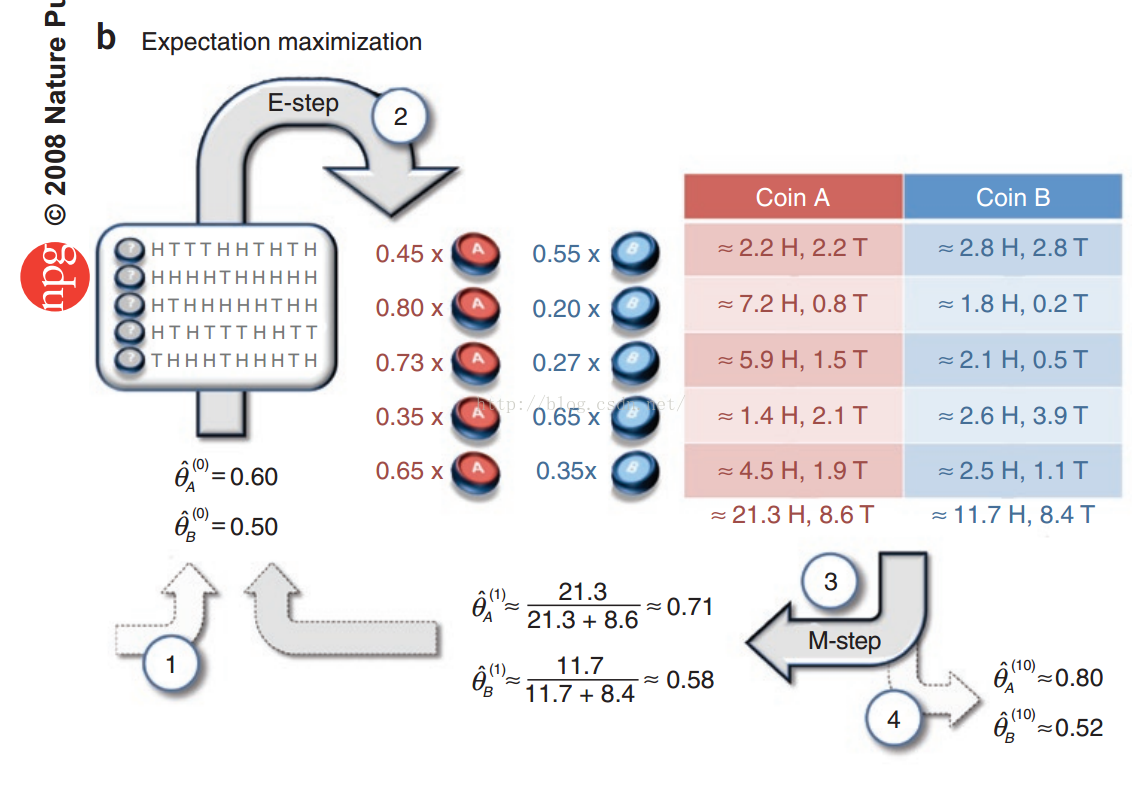

具体计算：
1. 随机初始化$\theta_A = 0.6$, $\theta_B = 0.5$
2. （E步）对于硬币A，5正5反的概率为：$0.6^5\times 0.4^5$；对于硬币B，5正5反的概率为：$0.5^5\times 0.5^5$。因此硬币属于A或者B的概率分别为：
\begin{equation}
P_A = \frac{0.6^5\times 0.4^5}{0.6^5\times 0.4^5+0.5^5\times 0.5^5}=0.45 \\
P_B = \frac{0.5^5\times 0.5^5}{0.6^5\times 0.4^5+0.5^5\times 0.5^5} = 0.55
\end{equation}
即此处估计了隐含变量$z$的概率分布。这时分别使用概率分布分别求硬币A和B的期望贡献，以第二轮为例：
\begin{equation}
H: 0.8\times 9 = 7.2\\
T: 0.8\times 1 = 0.8
\end{equation}
3. （M步）最大化参数估计。利用所有样本的期望分别更新新的参数值：
\begin{equation}
\theta_A = \frac{21.3}{21.3+8.6} = 0.71 \\
\theta_B = \frac{11.7}{11.7+8.4} = 0.58 \\
\end{equation}
4. 重复以上过程

In [18]:
import numpy as np
"""
双硬币模型求解
"""
def _lik(array, thetas):
    # 似然函数
    thetaA = thetas[0]
    thetaB = thetas[1]    
    """
    k 这个结果出现了，它是由A 抛出来的概率就是似然。既似然其实就是一个条件概率
    表示这个结果是A 抛出来的可能性有多大
    """
    n = len(array)    # 总共抛n 次
    k = np.sum(array) # 正面向上的次数是k
    
    H_A = ( thetaA ** k ) * ( 1 - thetaA ) ** (n - k)  # 由A 来抛，出现这个结果的概率
    H_B = ( thetaB ** k ) * ( 1 - thetaB ) ** (n - k)  # 由B 来抛，出现这个结果的概率
    
    """
    用贝叶斯定理算出似然值
    """    
    lik_A = H_A / ( H_A + H_B )  # 这个结果是A 抛的概率
    lik_B = H_B / ( H_A + H_B )  # 这个结果是B 抛的概率
    
    return lik_A, lik_B, n, k

"""
自已生成模似数据的方法
"""
true_thetas = [0.45, 0.75]
arrays=[]
for i in range(100):
    theta = true_thetas[ np.random.randint(0,2) ]  # 随机选一枚硬币
    array = np.random.binomial(size=10, p=theta, n=1)  # 抛10 次。二项分布，值为1 的概率由p 给出
    arrays.append(array)

max_iter=20
thetas = [ 0.3, 0.4 ]  # 未知参数开始时先随便估计一个值 

for _ in range(max_iter):
    E_A = []; E_B = []
    for i in range(len(arrays)):
        lik_A, lik_B, n, k = _lik( arrays[i], thetas  ) # 这个结果是A 抛的概率、B 抛的概率、总共抛n 次、结果是k 次正面向上
        E_A.append( [ lik_A * k, lik_A  * ( n - k ) ] )  # k 次正面的单次期望，n - k 次反面的单次期望
        E_B.append( [ lik_B * k, lik_B  * ( n - k ) ] )        
    E_A = np.sum(E_A, axis=0) # 按列连加
    E_B = np.sum(E_B, axis=0)
    """
    更新参数（用期望来算概率）
    """
    thetas[0] = E_A[0] / (E_A[0] + E_A[1])
    thetas[1] = E_B[0] / (E_B[0] + E_B[1])
    print(thetas)


[0.4544879368079539, 0.6572421648783082]
[0.43542066368875865, 0.7299101603000764]
[0.4216352621871988, 0.760462421968739]
[0.41997932430129276, 0.7709002533844229]
[0.4211021111896905, 0.7746665104068219]
[0.4221379279063176, 0.7762493812639176]
[0.42276612843239947, 0.7769905417726745]
[0.4231084094262185, 0.7773568258113799]
[0.42328820244718335, 0.7775421176026716]
[0.4233813705836388, 0.777636745801214]
[0.42342940104090004, 0.777685255078487]
[0.42345411291210616, 0.7777101593599726]
[0.4234668176486959, 0.7777229524544023]
[0.4234733474646504, 0.7777295256355561]
[0.4234767032136032, 0.7777329032792782]
[0.4234784277040001, 0.7777346389481472]
[0.4234793138921447, 0.7777355308675423]
[0.42347976928790076, 0.7777359892062332]
[0.4234800033070257, 0.777736224737331]
[0.42348012356490494, 0.7777363457721428]


### 作业
仿照本讲义中双硬币模型的EM求解代码，编写三硬币模型的EM求解代码。

In [1]:
import numpy as np

# 模拟数据
true_thetas = [0.3, 0.6, 0.8]  # 三枚硬币真实的正面概率
arrays = []

for _ in range(100):
    idx = np.random.randint(0, 3)  # 随机选择 A, B 或 C 硬币
    theta = true_thetas[idx]
    array = np.random.binomial(size=10, p=theta, n=1)  # 抛10次，记录结果
    arrays.append(array)

# E-step: 计算每一组数据来自三枚硬币的概率（似然）
def _lik(array, thetas):
    n = len(array)
    k = np.sum(array)

    H = []
    for theta in thetas:
        h = (theta ** k) * ((1 - theta) ** (n - k))
        H.append(h)
    
    total = sum(H)
    liks = [h / total for h in H]  # 归一化为条件概率
    return liks, n, k

# 初始化参数
thetas = [0.2, 0.5, 0.7]  # 初始估计
max_iter = 20

for _ in range(max_iter):
    E = [[], [], []]  # 三个硬币的期望累积

    for array in arrays:
        liks, n, k = _lik(array, thetas)
        for i in range(3):
            E[i].append([liks[i] * k, liks[i] * (n - k)])  # 正面与反面期望

    for i in range(3):
        E[i] = np.sum(E[i], axis=0)
        thetas[i] = E[i][0] / (E[i][0] + E[i][1])  # 更新 theta

    print(f"Iteration {_ + 1}: {thetas}")


Iteration 1: [np.float64(0.23710130717691671), np.float64(0.5268810456975174), np.float64(0.7458940247018183)]
Iteration 2: [np.float64(0.259275603619594), np.float64(0.546388872492899), np.float64(0.765154851835942)]
Iteration 3: [np.float64(0.27187595438251105), np.float64(0.5617269561644698), np.float64(0.7738979801882969)]
Iteration 4: [np.float64(0.2790293958644667), np.float64(0.5735454516619947), np.float64(0.7779716528600069)]
Iteration 5: [np.float64(0.28320860350336813), np.float64(0.5824983525041008), np.float64(0.7797681800257008)]
Iteration 6: [np.float64(0.2857622660241621), np.float64(0.5892294516478109), np.float64(0.780405608024594)]
Iteration 7: [np.float64(0.28739842654013803), np.float64(0.5942881739766777), np.float64(0.7804591249162748)]
Iteration 8: [np.float64(0.2884909662929904), np.float64(0.5981060056836215), np.float64(0.7802374814844687)]
Iteration 9: [np.float64(0.28924495942343054), np.float64(0.6010062869839704), np.float64(0.7799063996108722)]
Iteration